In [3]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools

In [ ]:
# --- Ackley関数の定義 ---
def evalAckley(individual):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(individual)
    x = np.array(individual)
    sum_sq_term = -b * np.sqrt(np.sum(x**2) / n)
    cos_term = np.sum(np.cos(c * x)) / n
    result = -a * np.exp(sum_sq_term) - np.exp(cos_term) + a + np.e
    return (result,)

# --- GAの基本設定 ---
NDIM = 30
BOUND_L, BOUND_U = -32.768, 32.768

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# --- Toolboxの初期化 ---
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, BOUND_L, BOUND_U)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NDIM)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- 遺伝的演算子の登録 ---
toolbox.register("evaluate", evalAckley)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_L, up=BOUND_U, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_L, up=BOUND_U, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selTournament, tournsize=3)

# --- GAの実行 ---

def main():
    random.seed(64)
    
    # パラメータ設定
    POP_SIZE = 300
    CXPB = 0.9
    MUTPB = 0.2
    NGEN = 400

    # 集団を生成
    pop = toolbox.population(n=POP_SIZE)
    
    # 最良個体を保存するためのHallOfFameオブジェクト
    hof = tools.HallOfFame(1)
    
    # 統計情報とLogbookの設定
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "nevals", "min", "avg", "std"

    # --- 進化計算ループ ---
    
    # 1. 最初の世代の適応度を評価
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # LogbookとHallOfFameを最初の世代で更新
    hof.update(pop)
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    print(logbook.stream) # 最初の世代の統計情報を表示

    # 2. 世代交代のループ (tqdmでプログレスバーを表示)
    for gen in tqdm(range(1, NGEN + 1)):
        # 次世代の個体を選択
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # 交叉
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # 突然変異
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # 適応度が無効な個体を評価
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # 次世代集団を更新
        pop[:] = offspring
        
        # LogbookとHallOfFameを更新
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        # print(logbook.stream) # ←各世代の情報を表示したい場合はコメントアウトを外す

    # --- 結果の表示 ---
    print("\n--- 最良個体 ---")
    print(f"個体: {hof[0]}")
    print(f"適応度 (Ackley関数の値): {hof[0].fitness.values[0]}")

    # --- グラフの描画 ---
    gen = logbook.select("gen")
    avg = logbook.select("avg")
    std = logbook.select("std")
    min_ = logbook.select("min")

    fig, ax1 = plt.subplots()
    
    # 平均値のプロット (実線)
    line1 = ax1.plot(gen, avg, "b-", label="Average Fitness")
    # 最小値のプロット (一点鎖線)
    line2 = ax1.plot(gen, min_, "g-.", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    
    # 平均値±標準偏差の範囲を塗りつぶし
    std_upper = np.array(avg) + np.array(std)
    std_lower = np.array(avg) - np.array(std)
    ax1.fill_between(gen, std_lower, std_upper, color='b', alpha=0.2, label="Avg +/- Std Dev")
    
    ax1.legend(loc="upper right")
    plt.title("Fitness over Generations")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [5]:
# --- GAの基本設定 ---

# 問題の次元数 (Ackley関数の変数の数)
NDIM = 30

# 探索範囲の境界
BOUND_L, BOUND_U = -32.768, 32.768

# 最小化問題として設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# 個体の定義 (リスト型で、適応度としてFitnessMinを持つ)
creator.create("Individual", list, fitness=creator.FitnessMin)

# --- Toolboxの初期化 ---
toolbox = base.Toolbox()

# 属性(遺伝子)の生成方法を定義 (範囲内の浮動小数点数)
toolbox.register("attr_float", random.uniform, BOUND_L, BOUND_U)

# 個体(Individual)の生成方法を定義
# initRepeatコンテナ(creator.Individual)に、attr_floatをNDIM回繰り返して個体を生成
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NDIM)

# 集団(Population)の生成方法を定義
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# --- 遺伝的演算子の登録 ---

# 評価関数
toolbox.register("evaluate", evalAckley)
# 交叉: シミュレーテッドバイナリ交叉(SBX)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_L, up=BOUND_U, eta=20.0)
# 突然変異: 多項式突然変異
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_L, up=BOUND_U, eta=20.0, indpb=1.0/NDIM)
# 選択: トーナメント選択
toolbox.register("select", tools.selTournament, tournsize=3)

/home/ryoaki374/.deap/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ryoaki374/.deap/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    	std     
0  	300   	20.5596	21.2252	0.201898


100%|██████████| 400/400 [00:10<00:00, 36.70it/s]



--- 最良個体 ---
個体: [0.00044545718297836257, -0.021765957457365717, -0.021324505043888668, 0.007305829975285892, 0.00019942946238409143, -0.0005182999107871234, -0.002819139082842889, -0.006568863024739477, 0.0006275465940974974, 0.002974558544088581, 0.0015479317605413684, 0.003043481716783003, 0.00019699987047145948, 0.009441023560549048, 0.00387603536301703, -4.206001795901243e-05, -0.014639634918920334, -0.0014916291173779296, -0.0046645048385109454, 0.014114741410803178, 0.00022923425101803053, 3.1936671511820156e-05, 0.004207532505428808, -0.024424009618786255, -0.0003722528001115505, 0.006941780032475961, 0.0006136614589957912, 2.2611869854838418e-05, -0.010462443087979145, 0.0034081633566653705]
適応度 (Ackley関数の値): 0.039845687210040115


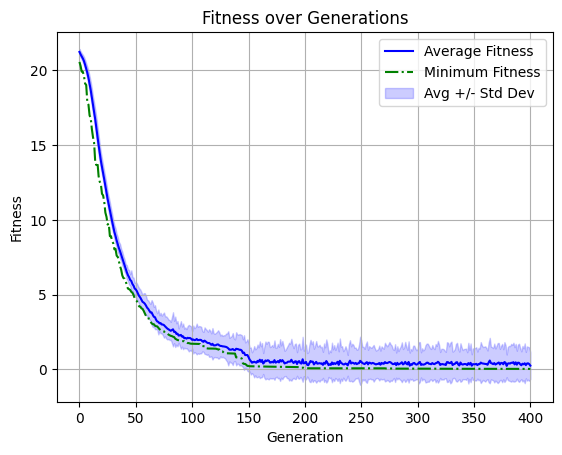

In [6]:
# --- GAの実行 ---

def main():
    random.seed(64)
    
    # パラメータ設定
    POP_SIZE = 300
    CXPB = 0.9
    MUTPB = 0.2
    NGEN = 400

    # 集団を生成
    pop = toolbox.population(n=POP_SIZE)
    
    # 最良個体を保存するためのHallOfFameオブジェクト
    hof = tools.HallOfFame(1)
    
    # 統計情報とLogbookの設定
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "nevals", "min", "avg", "std"

    # --- 進化計算ループ ---
    
    # 1. 最初の世代の適応度を評価
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # LogbookとHallOfFameを最初の世代で更新
    hof.update(pop)
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    print(logbook.stream) # 最初の世代の統計情報を表示

    # 2. 世代交代のループ (tqdmでプログレスバーを表示)
    for gen in tqdm(range(1, NGEN + 1)):
        # 次世代の個体を選択
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # 交叉
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # 突然変異
        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # 適応度が無効な個体を評価
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # 次世代集団を更新
        pop[:] = offspring
        
        # LogbookとHallOfFameを更新
        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        # print(logbook.stream) # ←各世代の情報を表示したい場合はコメントアウトを外す

    # --- 結果の表示 ---
    print("\n--- 最良個体 ---")
    print(f"個体: {hof[0]}")
    print(f"適応度 (Ackley関数の値): {hof[0].fitness.values[0]}")

    # --- グラフの描画 ---
    gen = logbook.select("gen")
    avg = logbook.select("avg")
    std = logbook.select("std")
    min_ = logbook.select("min")

    fig, ax1 = plt.subplots()
    
    # 平均値のプロット (実線)
    line1 = ax1.plot(gen, avg, "b-", label="Average Fitness")
    # 最小値のプロット (一点鎖線)
    line2 = ax1.plot(gen, min_, "g-.", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    
    # 平均値±標準偏差の範囲を塗りつぶし
    std_upper = np.array(avg) + np.array(std)
    std_lower = np.array(avg) - np.array(std)
    ax1.fill_between(gen, std_lower, std_upper, color='b', alpha=0.2, label="Avg +/- Std Dev")
    
    ax1.legend(loc="upper right")
    plt.title("Fitness over Generations")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()